## Comparing No Trauma vs. Experienced Trauma Survival Models for Probability of Marijuana Relapse

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
import seaborn as sns
import numpy as np
from IPython.display import display_html
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [47]:
# function to display pandas dataframes in segments, side-by-side
def display_side_by_side(df, n):
    temp = int(round(len(missing_value_df) / n))
    args = []
    for i in range(n):
        if i != n-1:
            args.append(df[temp*i:temp*(i+1)].copy())
        else:
            args.append(df[temp*i:len(df)].copy())
    helper(args)

# helper function that manipulates html to print df
def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [48]:
# read csv from github url
# return pandas dataframe
url = 'https://raw.githubusercontent.com/prathikr/CS_499_Final_Project/master/BISTRA_GROUP_PROJECT_SMALL.csv'
df = pd.read_csv(url)
df.head()

,ID,female,nonwhite,unemplmt,primsev,B2a_0,State,City,zipcode,noins,prsatx,tottxp4,TRI_0,GVS,E9a,E9b,E9c,E9d,E9e,E9e18,E9f,E9g,E9h,E9j,E9k,E9m,tsd_0,und15,CWS_0,IPI,L5,SPSy_0,RFQ33c,GSSI_0,S9y10,dldiag,press,DSS9_0,ADHDs_0,CDS_0,suicprbs_0,CJSI_0,LRI7_0,SRI7_0,ERS21_0,homeless_0,S6,PSSI_0,RERI13p_0,ncar,loc,engage30,engage42,init,S7e4_0,POPIgrp,FIS4p_0,HIVrisk,agyaddr,txtypeg,SDScrY,totttld,POS_0,AFSS_0,S2x_0,SPSm_0,E14a_0,E14b_0,EPS7p_0,SFS8p_0,SFS8p_3,SFS8p_6,SFS8p_12,ada_0,ada_3,ada_6,ada_12,S2c1_0,S2c1_3,S2c1_6,S2c1_12,S2b1_0,S2b1_3,S2b1_6,S2b1_12,S2z1_3,S2z1_6,S2z1_12,S2z2_3,S2z2_6,S2z2_12,S2z3_3,S2z3_6,S2z3_12,S2z4_3,S2z4_6,S2z4_12,S2z5_3,S2z5_6,S2z5_12,Any_Cens,Alcohol_Cens,Binge_Cens,Marijuana_Cens,Illicit_Cens,Any_Days,Alcohol_Days,Binge_Days,Marijuana_Days,Illicit_Days
0,9048,0,0,0,4,17,VA,Lynchburg,24501-1114,0,1,19,0,4,1,1,0,0,5,1,0,1,0,0,0,0,1,1,0,4,7,16,-999,6,8,1,1,7,8,7,0,100.000000,4,12,34,1,1,3,16.666667,0,4,1,1,1,0,-999,0.0,7,"2215 Langhorne Road, Suite 2-B",2,5,1021,0,5,56,0,65,0,55.396825,0.277778,-999.000000,0.000000,-999.000000,11,-999,83,-999,0,-999,0,-999,0,-999,0,-999,-999,90,-999,-999,90,-999.0,-999,90,-999,-999,90,-999,-999,90,-999,2,2,2,2,2,192,192,192,192,192
1,9152,0,0,0,1,18,VA,Lynchburg,24501-1114,0,0,21,1,8,1,1,0,1,14,1,1,1,1,1,0,0,1,1,0,6,4,0,-999,8,8,1,0,6,13,2,1,54.444444,11,18,37,0,0,3,31.111111,1,4,1,1,1,0,-999,0.0,10,"2215 Langhorne Road, Suite 2-B",2,0,1009,0,4,29,0,1,89,41.269841,0.277778,-999.000000,0.000000,-999.000000,54,-999,90,-999,0,-999,0,-999,-999,-999,0,-999,-999,90,-999,-999,90,-999.0,-999,90,-999,-999,90,-999,-999,-999,-999,2,2,2,2,2,176,176,176,176,176
2,9057,0,0,1,3,16,VA,Lynchburg,24501-1114,0,0,16,1,4,0,0,0,1,16,1,0,0,1,0,0,0,0,1,0,3,0,6,-999,9,8,1,1,2,5,4,1,0.000000,8,11,40,0,0,1,18.376068,0,4,1,1,1,0,-999,0.0,4,"2215 Langhorne Road, Suite 2-B",2,3,996,0,2,0,2,15,0,19.841270,18.611111,1.111111,0.833333,0.416667,14,86,87,89,45,0,0,1,3,2,3,0,21,87,81,21,87,90.0,-999,87,90,0,0,81,-999,-999,-999,0,0,2,0,2,21,21,365,81,365
3,9139,0,0,0,3,16,VA,Lynchburg,24501-1114,0,0,14,0,0,0,0,0,0,-999,0,0,0,0,0,0,0,0,1,0,2,1,6,-999,2,1,-999,1,1,4,2,0,100.000000,8,18,44,0,0,0,25.811966,1,4,0,1,1,0,-999,0.0,4,"2215 Langhorne Road, Suite 2-B",2,2,980,0,0,5,0,40,30,12.698413,7.638889,2.500000,1.944444,0.000000,50,84,53,90,12,3,0,0,5,0,2,0,20,1,90,-999,1,90.0,90,0,90,20,0,90,-999,0,-999,0,2,0,0,2,20,365,0,20,365
4,9051,0,1,0,3,17,VA,Lynchburg,24501-1114,0,0,12,0,0,0,0,0,0,-999,0,0,0,0,0,0,0,0,0,2,5,1,4,-999,7,8,0,1,1,7,3,0,62.222222,9,-999,33,0,0,1,24.017094,0,4,1,1,1,0,-999,25.0,0,"2215 Langhorne Road, Suite 2-B",2,2,946,0,1,0,3,4,0,30.158730,4.861111,2.222222,24.285714,14.166667,60,82,15,51,3,6,75,39,0,2,3,0,14,7,2,30,7,30.0,30,7,-999,14,7,2,-999,-999,-999,0,0,0,0,1,14,30,30,14,356


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2448c828>]],
      dtype=object)

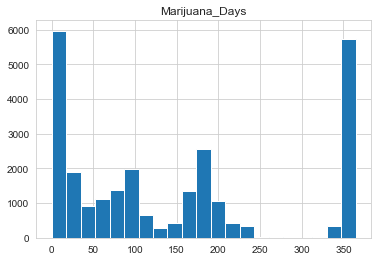

In [49]:
# remove rows without Marijuana_Days value
df = df[df.Marijuana_Days != -999] # removes all rows with Marijuana_Days = -999
df.hist(column='Marijuana_Days', bins=21) # 21 chosen so that there would be 3 bins between each x-axis number

In [50]:
# calculate trauma score (based on domain expert suggestion)
df['trauma'] = (df.E9a & df.E9b) + df.E9c + df.E9d

In [51]:
# trim unnecessary columns 

print("Original df:", df.shape)

unused_potential_predictors = ['SFS8p_0', 'SFS8p_3', 'SFS8p_6', 'SFS8p_12', 'ada_0','ada_3',
'ada_6','ada_12','S2c1_0','S2c1_3','S2c1_6','S2c1_12','S2b1_0','S2b1_3','S2b1_6','S2b1_12','S2z1_3','S2z1_6',
'S2z1_12','S2z2_3','S2z2_6','S2z2_12','S2z3_3','S2z3_6','S2z3_12','S2z4_3','S2z4_6','S2z4_12','S2z5_3','S2z5_6',
'S2z5_12','Any_Cens','Alcohol_Cens','Binge_Cens','Marijuana_Cens','Illicit_Cens','Any_Days','Binge_Days',
'Alcohol_Days','Illicit_Days']

# TO DO: SUM RELEVANT E9? VARIABLES BASED ON SEXUAL, EMOTIONAL, AND PHYSICAL TRAUMA
domain_expert_cols_to_drop = ['SPSy_0', 'loc', 'AFSS_0', 'E9a', 'E9b', 'E9c', 'E9d', 'E9e', 'E9e18', 'E9f', 'ID', 
'E9g', 'E9h', 'E9j', 'E9k', 'E9m', 'txtypeg', 'S7e4_0', 'engage42', 'POPIgrp','L5', 'E14a_0', 'E14b_0', 'SDScrY']

unused_labelling_columns = ['City', 'agyaddr', 'zipcode', 'State']

cols_to_drop = unused_labelling_columns + domain_expert_cols_to_drop + unused_potential_predictors

# drop columns and isolate to specific substance
df.drop(columns=cols_to_drop, inplace=True)
df = df[df.primsev == 3] # leaves only marijuana drug abusers in dataframe
df.drop(columns=['primsev'], inplace=True)
print("Updated df:", df.shape)

Original df: (26490, 111)
Updated df: (14166, 42)


In [52]:
# replace all -999 with NaN inplace
df.replace(to_replace = -999, value = np.nan, inplace=True)

# calculate percentage of NaNs in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
display_side_by_side(missing_value_df, 3)

,column_name,percent_missing
female,female,0.000000
nonwhite,nonwhite,0.035296
unemplmt,unemplmt,0.197656
B2a_0,B2a_0,0.000000
noins,noins,59.819286
prsatx,prsatx,0.268248
tottxp4,tottxp4,0.000000
TRI_0,TRI_0,1.221234
GVS,GVS,0.176479
tsd_0,tsd_0,0.232952


In [53]:
print("Original df:", df.shape)

# drop columns with > 25% NaNs
df = df.loc[:, df.isnull().sum() < 0.25*df.shape[0]]
print("new df shape:", df.shape)

Original df: (14166, 42)
new df shape: (14166, 35)


In [54]:
# identify boolean columns
bool_cols = [col for col in df 
             if np.isin(df[col].dropna().unique(), [0, 1]).all()]
print(bool_cols)

['female', 'nonwhite', 'unemplmt', 'prsatx', 'tsd_0', 'und15', 'dldiag', 'suicprbs_0', 'homeless_0', 'S6', 'ncar', 'engage30', 'init']


In [55]:
# replace boolean column NaNs with mode
for column in bool_cols:
    df[column].fillna(df[column].mode()[0], inplace=True)
    
# since binary columns are filled we can just replace all other NaNs with mean
for column in df.columns:
    df[column].fillna(df[column].mean(), inplace=True)

# check to ensure entire df has no null values**
og_df_shape = df.shape
df = df.loc[:, df.isnull().sum() <= 0*df.shape[0]] # Drop columns with >0% missing values
new_df_shape = df.shape

if (og_df_shape != new_df_shape): # if any columns were dropped, we know df had null values
    print("ERROR: df contained null values")
else:
    print("no null values!")

no null values!


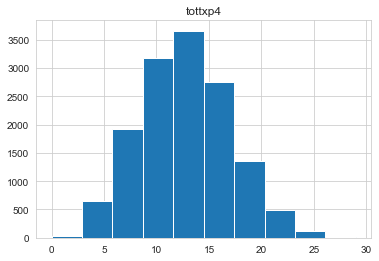

In [56]:
# normalize columns that are numerical/continuous
numerical_cols = ['tottxp4', 'CWS_0', 'ADHDs_0', 'CDS_0', 'CJSI_0', 'EPS7p_0', 'LRI7_0', 'SRI7_0', 
          'ERS21_0', 'HIVrisk', 'totttld', 'S2x_0', 'SPSm_0']

# visualize tottxp4 histogram before normalization as a sanity check
df.hist(column=numerical_cols[0])

scaler = preprocessing.StandardScaler()
for col in numerical_cols:
    df[col] = scaler.fit_transform(df[[col]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24babd68>]],
      dtype=object)

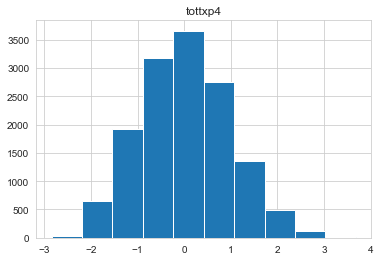

In [57]:
# visualize tottxp4 histogram after normalization as a sanity check
df.hist(column=numerical_cols[0])

In [58]:
# segment data by race (male == No Trauma, female == Experienced Trauma)
# no reason for male/female discrimination, just too lazy to change variable names since copied from M_vs_F notebook

X_m = df[df.GVS == 0].copy()
X_f = df[df.GVS == 1].copy()
X_m.drop(columns=['GVS'], inplace=True)
X_f.drop(columns=['GVS'], inplace=True)

print("No Trauma Data Shape:", X_m.shape, "Experienced Trauma Data Shape:", X_f.shape)

No Trauma Data Shape: (5548, 34) Experienced Trauma Data Shape: (547, 34)


In [59]:
# further segment data into training and test sets
X_m_tr, X_m_te = train_test_split(X_m, test_size=0.2)
X_f_tr, X_f_te = train_test_split(X_f, test_size=0.2)

print("No Trauma Training Data Shape:", X_m_tr.shape)
print("No Trauma Testing Data Shape:", X_m_te.shape)
print("Experienced Trauma Training Data Shape:", X_f_tr.shape)
print("Experienced Trauma Testing Data Shape:", X_f_te.shape)

No Trauma Training Data Shape: (4438, 34)
No Trauma Testing Data Shape: (1110, 34)
Experienced Trauma Training Data Shape: (437, 34)
Experienced Trauma Testing Data Shape: (110, 34)


In [60]:
# extract Marijuana_Days predictor
Y_m_tr = X_m_tr['Marijuana_Days'].copy()
Y_m_te = X_m_te['Marijuana_Days'].copy()
Y_f_tr = X_f_tr['Marijuana_Days'].copy()
Y_f_te = X_f_te['Marijuana_Days'].copy()
X_m_tr.drop(columns=['Marijuana_Days'], inplace=True)
X_m_te.drop(columns=['Marijuana_Days'], inplace=True)
X_f_tr.drop(columns=['Marijuana_Days'], inplace=True)
X_f_te.drop(columns=['Marijuana_Days'], inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [61]:
# generate male-only model with male training data
Y_m_tr_censored = Surv.from_arrays(Y_m_tr < 365, Y_m_tr.copy()) # structured array to ensure censoring of 365 value
model_m = CoxPHSurvivalAnalysis()
model_m.fit(X_m_tr, Y_m_tr_censored)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [62]:
# generate female-only model with female training data
Y_f_tr_censored = Surv.from_arrays(Y_f_tr < 365, Y_f_tr.copy()) # structured array to ensure censoring of 365 value
model_f = CoxPHSurvivalAnalysis()
model_f.fit(X_f_tr, Y_f_tr_censored)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [63]:
# predict on male test data
pred_surv_m = model_m.predict_survival_function(X_m_te)
pred_haz_m = model_m.predict_cumulative_hazard_function(X_m_te)
Y_m_te_censored = Surv.from_arrays(Y_m_te < 365, Y_m_te.copy()) # structured array to ensure censoring of 365 value
score_m = model_m.score(X_m_te, Y_m_te_censored)

In [64]:
# predict on female test data
pred_surv_f = model_f.predict_survival_function(X_f_te)
pred_haz_f = model_f.predict_cumulative_hazard_function(X_f_te)
Y_f_te_censored = Surv.from_arrays(Y_f_te < 365, Y_f_te.copy()) # structured array to ensure censoring of 365 value
score_f = model_f.score(X_f_te, Y_f_te_censored)

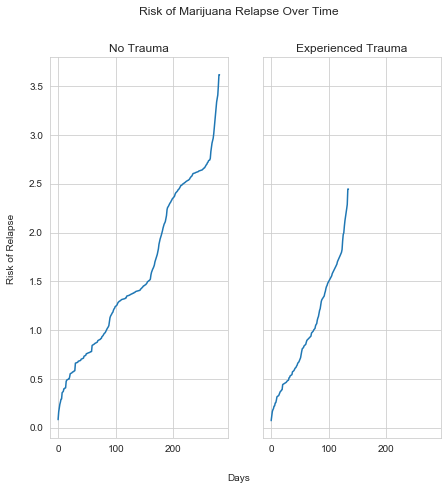

In [65]:
# display hazard plots side-by-side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,7))
fig.suptitle('Risk of Marijuana Relapse Over Time')
ax1.set_title('No Trauma')
ax2.set_title('Experienced Trauma')
fig.text(0.5, 0.04, 'Days', ha='center')
fig.text(0.04, 0.5, 'Risk of Relapse', va='center', rotation='vertical')
ax1.plot(np.mean([person.y for person in pred_haz_m], axis=0))
ax2.plot(np.mean([person.y for person in pred_haz_f], axis=0))

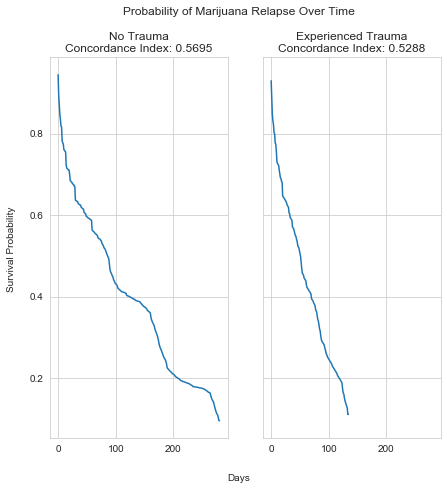

In [66]:
# display survival plots side-by-side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,7))
fig.suptitle('Probability of Marijuana Relapse Over Time')
ax1.set_title('No Trauma\nConcordance Index: ' + str(round(score_m, 4)))
ax2.set_title('Experienced Trauma\nConcordance Index: ' + str(round(score_f, 4)))
fig.text(0.5, 0.04, 'Days', ha='center')
fig.text(0.04, 0.5, 'Survival Probability', va='center', rotation='vertical')
ax1.plot(np.mean([person.y for person in pred_surv_m], axis=0))
ax2.plot(np.mean([person.y for person in pred_surv_f], axis=0))

In [67]:
# display feature importance
coefs = pd.DataFrame({'Coefficient':X_m_tr.columns, 'No Trauma':model_m.coef_, 'Experienced Trauma':model_f.coef_})
display_side_by_side(coefs, 3)

,Coefficient,No Trauma,Experienced Trauma
0,female,0.023224,-0.225559
1,nonwhite,0.008132,0.133418
2,unemplmt,-0.116178,-0.231433
3,B2a_0,-0.016694,0.011112
4,prsatx,0.129079,-0.231495
5,tottxp4,0.000750,-0.024879
6,TRI_0,0.044768,-0.050994
7,tsd_0,-0.146980,-0.065187
8,und15,0.066527,-0.089212
9,CWS_0,-0.018664,-0.149403
